# Libraries

In [1]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# reading data
from os.path import basename
import json
from collections import defaultdict
import glob
import re

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Linear Model

In [10]:
# Define the pattern to match the filenames
pattern = "df_(.*?)_(.*?)_pred(.*?)_(.*?).csv"

# Use glob to find all csv files matching the pattern
files = glob.glob('../data/Results/df_*_*_pred*_*.csv')

# Initialize a dictionary to hold the data frames
linear_dfs = {}

for file in files:
    # Extract the basename of the file for regex matching
    file_basename = basename(file)
    
    # Extract model name, embedding length, and loss function using regex
    match = re.match(pattern, file_basename)
    if match:
        result_type = match.group(1)
        model_name = match.group(2)
        prediction_length = match.group(3)
        loss_function = match.group(4)

        # Read the csv file into a pandas DataFrame
        df = pd.read_csv(file)

        # Store the DataFrame in the dictionary with a tuple key for easy sorting
        linear_dfs[(result_type, model_name, int(prediction_length), loss_function)] = df
    else:
        # If no match, print the filename for review
        print(f"No match for file: {file_basename}")

## LaTeX Tables

In [3]:
def SystemUsage_LaTeX(data_frames, model_type='Linear', prediction_lengths=[1, 6, 72, 144], loss_functions=['CRPS', 'MSELoss', 'L1Loss']):
    """
    Generates LaTeX table code with system usage statistics filled in for given model types,
    loss functions, and embedding lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - prediction_length: List of Forecast Horizons.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, prediction_length): {'max_cpu': '', 'max_ram': '', 'max_gpu': '', 'avg_cpu': '', 'avg_ram': '', 'avg_gpu': ''} 
             for loss_function in loss_functions for prediction_length in prediction_lengths}
    
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'SystemUsage' and key[1] == model_type and key[2] in prediction_lengths and key[3] in loss_functions:
            stats_key = (key[3], key[2])
            # Update stats with maximum values
            stats[stats_key]['max_cpu'] = round(system_df['CPU Usage'][1:].max(), 4)
            stats[stats_key]['max_ram'] = round(system_df['Memory Usage (GB)'].max(), 4)
            stats[stats_key]['max_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].max(), 4)
            # Update stats with average values
            stats[stats_key]['avg_cpu'] = round(system_df['CPU Usage'][1:].mean(), 4)
            stats[stats_key]['avg_ram'] = round(system_df['Memory Usage (GB)'].mean(), 4)
            stats[stats_key]['avg_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].mean(), 4)

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\footnotesize
    \\centering
    \\caption{""" + model_type + """ Model Hardware Results}
    \\begin{tabular}{l|l|S|S|S|S|S|S}
        \\toprule
        \\textbf{Loss} & \\textbf{Forecast} & \\multicolumn{3}{c|}{\\textbf{max Usage}} & \\multicolumn{3}{c}{\\textbf{avg Usage}} \\\\
        \\textbf{Function} & \\textbf{Horizon} & \\text{CPU (\\%)} & \\text{RAM (GB)} & \\text{GPU (GB)} & \\text{CPU (\\%)} & \\text{RAM (GB)} & \\text{GPU (GB)} \\\\
        \\midrule
    """
    for prediction_length in prediction_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, prediction_length)]
            latex_table += f"        {loss_function} & {prediction_length} & "
            latex_table += f"{stat['max_cpu']} & {stat['max_ram']} & {stat['max_gpu']} & "
            latex_table += f"{stat['avg_cpu']} & {stat['avg_ram']} & {stat['avg_gpu']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """    \\bottomrule
    \\end{tabular}
    \\label{tab:""" + model_type.lower() + """_hardware}
\\end{table}"""

    print(latex_table)

SystemUsage_LaTeX(linear_dfs, model_type='Linear')

\begin{table}
    \footnotesize
    \centering
    \caption{Linear Model Hardware Results}
    \begin{tabular}{l|l|S|S|S|S|S|S}
        \toprule
        \textbf{Loss} & \textbf{Forecast} & \multicolumn{3}{c|}{\textbf{max Usage}} & \multicolumn{3}{c}{\textbf{avg Usage}} \\
        \textbf{Function} & \textbf{Horizon} & \text{CPU (\%)} & \text{RAM (GB)} & \text{GPU (GB)} & \text{CPU (\%)} & \text{RAM (GB)} & \text{GPU (GB)} \\
        \midrule
            CRPS & 1 & 24.5 & 8.2529 & 0.416 & 15.5598 & 8.1493 & 0.416 \\
        MSELoss & 1 & 25.0 & 8.0487 & 0.3965 & 15.8084 & 7.8799 & 0.3936 \\
        L1Loss & 1 & 25.2 & 8.2727 & 0.416 & 15.8348 & 8.1863 & 0.416 \\
        \midrule
        CRPS & 6 & 24.2 & 8.2508 & 0.416 & 15.5146 & 8.1714 & 0.416 \\
        MSELoss & 6 & 25.6 & 8.1368 & 0.3965 & 15.8478 & 8.0447 & 0.3965 \\
        L1Loss & 6 & 25.5 & 8.3929 & 0.416 & 15.8739 & 8.2895 & 0.416 \\
        \midrule
        CRPS & 72 & 24.7 & 25.8702 & 0.416 & 15.5017 & 25.3396 & 0.416 \\
  

In [4]:
def Epoch_LaTeX(data_frames, model_type='Linear', prediction_lengths=[1, 6, 72, 144], loss_functions=['CRPS', 'MSELoss', 'L1Loss']):
    """
    Generates LaTeX table code with Epoch statistics filled in for given model types, loss functions, and prediction lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - prediction_lengths: List of Forecast Horizons.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, prediction_length): {'epochs': '', 'training_time': '', 'avg_epoch_time': '', 'loss': ''} 
             for loss_function in loss_functions for prediction_length in prediction_lengths}
    
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'epoch' and key[1] == model_type and key[2] in prediction_lengths and key[3] in loss_functions:
            stats_key = (key[3], key[2])  # (loss_function, prediction_length)
            # Update stats
            stats[stats_key]['epochs'] = len(system_df['Epoch Duration'])
            stats[stats_key]['training_time'] = round(sum(system_df['Epoch Duration']) / 60, 4)
            stats[stats_key]['avg_epoch_time'] = round(system_df['Epoch Duration'].mean(), 4)
        if key[0] == 'eval' and key[1] == model_type and key[2] in prediction_lengths and key[3] in loss_functions:
            stats_key = (key[3], key[2])  # (loss_function, prediction_length)
            # Update stats
            stats[stats_key]['loss'] = round(min(system_df['TestLoss']), 4)

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\footnotesize
    \\centering
    \\caption{""" + model_type + """ Model Epoch Results}
    \\begin{tabular}{l|l|r|S|S|S}
        \\toprule
        \\textbf{Loss} & \\textbf{Forecast} & \\textbf{Epochs} & \\textbf{Training} & \\textbf{Avg Epoch} & \\textbf{Test Loss} \\\\
        \\textbf{Function} & \\textbf{Horizon} & & \\textbf{Time (min)} & \\textbf{Duration (s)} & \\\\
        \\midrule
    """
    for prediction_length in prediction_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, prediction_length)]
            latex_table += f"        {loss_function} & {prediction_length} & {stat['epochs']} & {stat['training_time']} & {stat['avg_epoch_time']} & {stat['loss']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """    \\bottomrule
    \\end{tabular}
    \\label{tab:""" + model_type.lower() + """_epoch}
\\end{table}"""

    print(latex_table)

# Example usage
Epoch_LaTeX(linear_dfs, model_type='Linear')

\begin{table}
    \footnotesize
    \centering
    \caption{Linear Model Epoch Results}
    \begin{tabular}{l|l|r|S|S|S}
        \toprule
        \textbf{Loss} & \textbf{Forecast} & \textbf{Epochs} & \textbf{Training} & \textbf{Avg Epoch} & \textbf{Test Loss} \\
        \textbf{Function} & \textbf{Horizon} & & \textbf{Time (min)} & \textbf{Duration (s)} & \\
        \midrule
            CRPS & 1 & 9 & 16.5561 & 110.3743 & 0.5761 \\
        MSELoss & 1 & 12 & 21.3846 & 106.9229 & 840817.2209 \\
        L1Loss & 1 & 18 & 33.4259 & 111.4196 & 706.8088 \\
        \midrule
        CRPS & 6 & 14 & 25.359 & 108.6812 & 0.8748 \\
        MSELoss & 6 & 20 & 35.5379 & 106.6137 & 849046.452 \\
        L1Loss & 6 & 12 & 21.5681 & 107.8403 & 707.8288 \\
        \midrule
        CRPS & 72 & 19 & 47.5539 & 150.1701 & 0.6651 \\
        MSELoss & 72 & 14 & 34.6577 & 148.5329 & 842904.3729 \\
        L1Loss & 72 & 10 & 24.6159 & 147.6955 & 705.6111 \\
        \midrule
        CRPS & 144 & 13 & 46.4006 & 

## Visualizations

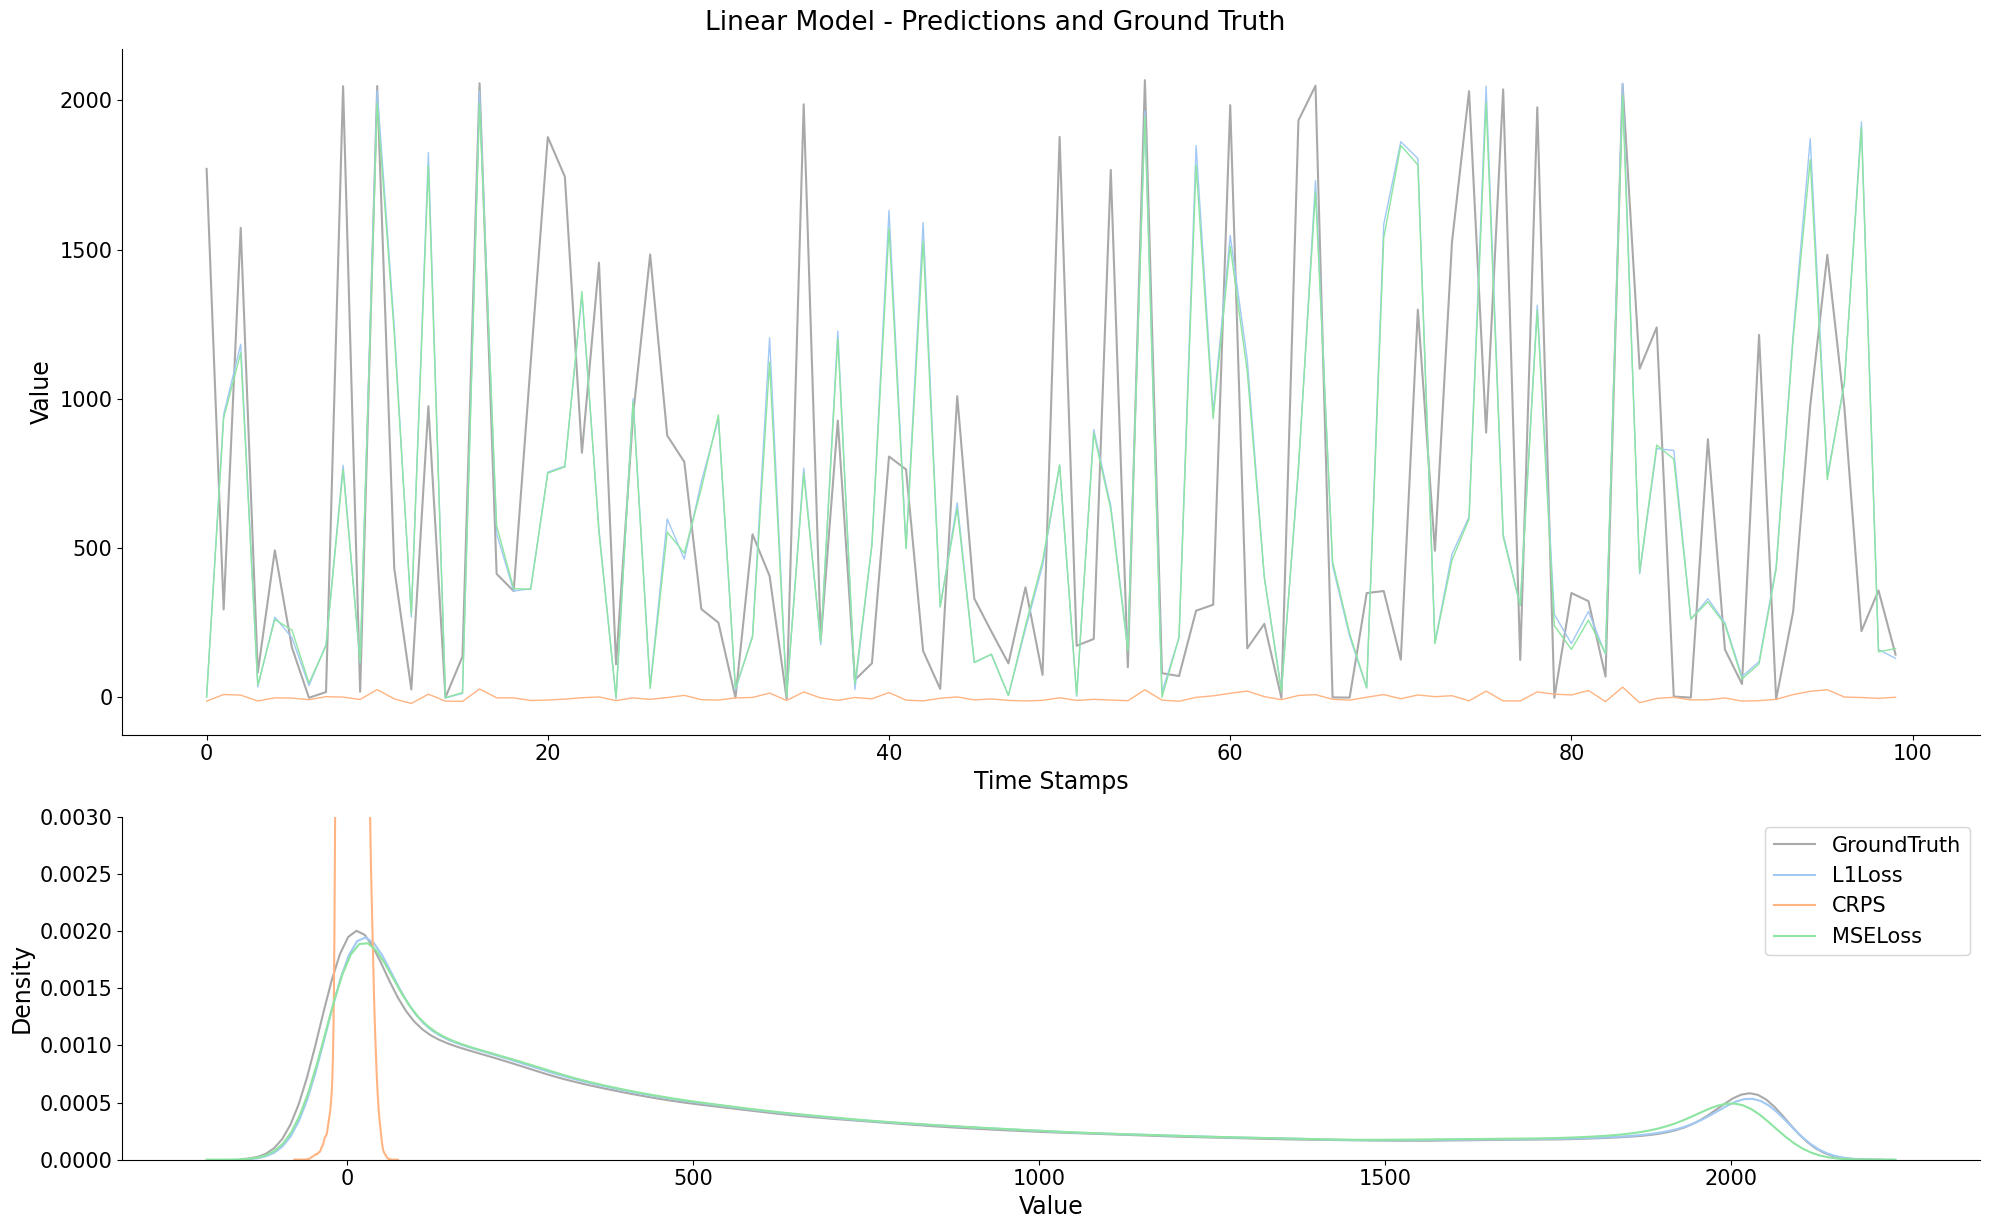

In [11]:
def eval_df_with_kde(model, data_frames, prediction_length, exclude_loss_functions=[]):
    """
    Aggregate predictions by model and loss function for 'eval' keys from the data frames,
    and plot both time series and KDE plots of predictions and ground truth, excluding specified loss functions from the KDE plot.

    Parameters:
    - model: String value of the Model to test.
    - data_frames: Dictionary mapping keys to pandas DataFrames.
    - exclude_loss_functions: List of loss function names to exclude from the KDE plot.

    Returns:
    - A matplotlib figure with time series and KDE plots.
    """
    # Initialize placeholders
    ground_truths = []
    predictions = {}
    
    # Loop over each key to process 'eval' data frames
    for key in data_frames.keys():
        if 'eval' in key and key[1] == model and key[2] == prediction_length:
            _, _, _, loss_function = key
            df = data_frames[key]
            
            # Extend the ground truths if this is a larger set
            if len(df) > len(ground_truths):
                ground_truths = df['GroundTruth'].str.strip('[]').astype(float).tolist()
            
            # Store predictions keyed by loss function
            predictions[loss_function] = df['Predictions'].str.strip('[]').astype(float).tolist()
    
    # Determine the maximum length needed for any column
    max_length = max(len(ground_truths), max(len(pred) for pred in predictions.values()))
    
    # Pad all prediction lists to the max length with NaN
    for loss_function in predictions:
        current_length = len(predictions[loss_function])
        if current_length < max_length:
            predictions[loss_function].extend([np.nan] * (max_length - current_length))
    
    # Assemble the final DataFrame
    aggregated_data = {'GroundTruth': ground_truths[:max_length]}
    aggregated_data.update(predictions)
    aggregated_df = pd.DataFrame(aggregated_data)

    # Define a consistent color palette
    ground_truth_color = 'darkgrey'  # or any color you prefer
    columns_to_plot = [col for col in aggregated_df.columns if col not in exclude_loss_functions and col != 'GroundTruth']
    palette = sns.color_palette("pastel", len(columns_to_plot))  # Adjust the palette as needed
    color_dict = {col: color for col, color in zip(columns_to_plot, palette)}

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 0.5]})
    tick_size=15
    
    # Time Series plot
    # Plot "GroundTruth" first so it's in the legend
    sns.lineplot(ax=ax[0], x=range(len(aggregated_df[:100])), y=aggregated_df[:100]['GroundTruth'], 
                 label='GroundTruth', color=ground_truth_color, linewidth=1.5)
    for column in columns_to_plot:
        sns.lineplot(ax=ax[0], x=range(len(aggregated_df[:100])), y=aggregated_df[:100][column], 
                     label=column, color=color_dict[column], linewidth=1)
    ax[0].set_xlabel('Time Stamps', fontsize=(tick_size + 2))
    ax[0].set_ylabel('Value', fontsize=(tick_size + 2))
    ax[0].legend().set_visible(False)  # Explicitly hide the legend
    ax[0].tick_params(labelsize=tick_size)

    sns.despine(ax=ax[0])  # Remove spines on right and top side
    
    # KDE plot
    # Plot "GroundTruth" KDE first so it's in the legend
    sns.kdeplot(ax=ax[1], data=aggregated_df['GroundTruth'], label='GroundTruth', color=ground_truth_color)
    for column in columns_to_plot:
        sns.kdeplot(ax=ax[1], data=aggregated_df[column], label=column, color=color_dict[column])
    ax[1].set_ylim([0, 0.003])
    ax[1].set_xlabel('Value', fontsize=(tick_size + 2))
    ax[1].set_ylabel('Density', fontsize=(tick_size + 2))
    ax[1].legend(title_fontsize=(tick_size + 1), fontsize=(tick_size))
    ax[1].tick_params(labelsize=tick_size)

    sns.despine(ax=ax[1])  # Remove spines on right and top side

    plt.tight_layout()  # Prevent overlapping

    # Set a title for the whole figure
    fig.suptitle(f'{model} Model - Predictions and Ground Truth', fontsize=(tick_size + 4), y=1.02)
    plt.savefig(f'../graphs/results/{model}_pred{prediction_length}_analysis.png', dpi=600, bbox_inches='tight')
    plt.show()

# Example usage:
eval_df_with_kde('Linear', linear_dfs, 144, exclude_loss_functions=[])


In [ ]:
def eval_df_with_kde(model, data_frames, prediction_length, embedding_length=32, exclude_loss_functions=[], tick_size=10):
    """
    Aggregate predictions by model and loss function for 'eval' keys from the data frames,
    and plot both time series and KDE plots of predictions and ground truth, excluding specified loss functions from the KDE plot.
    Now includes manual setting for tick sizes and modified KDE plot height.

    Parameters:
    - model: String value of the Model to test.
    - data_frames: Dictionary mapping keys to pandas DataFrames.
    - prediction_length: Integer, the length of the prediction period.
    - embedding_length: Integer, the dimension of embedding. Default is 32.
    - exclude_loss_functions: List of loss function names to exclude from the KDE plot.
    - tick_size: Integer, size of the ticks in the plots.

    Returns:
    - A matplotlib figure with time series and KDE plots.
    """
    # Initialize placeholders
    ground_truths = []
    predictions = {}
    
    # Loop over each key to process 'eval' data frames
    for key in data_frames.keys():
        if 'eval' in key and key[1] == model and key[2] == embedding_length and key[3] == prediction_length:
            _, _, _, _, loss_function = key
            df = data_frames[key]
            
            # Extend the ground truths if this is a larger set
            if len(df) > len(ground_truths):
                ground_truths = df['GroundTruth'].str.strip('[]').astype(float).tolist()
            
            # Store predictions keyed by loss function
            predictions[loss_function] = df['Predictions'].str.strip('[]').astype(float).tolist()            
    
    # Determine the maximum length needed for any column
    max_length = max(len(ground_truths), max(len(pred) for pred in predictions.values()))
    
    # Pad all prediction lists to the max length with NaN
    for loss_function in predictions:
        current_length = len(predictions[loss_function])
        if current_length < max_length:
            predictions[loss_function].extend([np.nan] * (max_length - current_length))
    
    # Assemble the final DataFrame
    aggregated_data = {'GroundTruth': ground_truths[:max_length]}
    aggregated_data.update(predictions)
    aggregated_df = pd.DataFrame(aggregated_data)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 0.5]})
    tick_size=15
    
    # Time Series plot
    sns.lineplot(ax=ax1, x=range(len(aggregated_df[:100])), y=aggregated_df[:100]['GroundTruth'], 
                 label='GroundTruth', color='darkgrey', linewidth=1)
    for column in [col for col in aggregated_df.columns if col not in exclude_loss_functions and col != 'GroundTruth']:
        sns.lineplot(ax=ax1, x=range(len(aggregated_df[:100])), y=aggregated_df[:100][column], 
                     label=column, linewidth=1)
    ax1.set_xlabel('Time Stamps', fontsize=(tick_size + 2))
    ax1.set_ylabel('Value', fontsize=(tick_size + 2))
    ax1.legend().set_visible(False)
    ax1.tick_params(labelsize=tick_size)

    # KDE plot
    sns.kdeplot(ax=ax2, data=aggregated_df['GroundTruth'], label='GroundTruth', color='darkgrey')
    for column in [col for col in aggregated_df.columns if col not in exclude_loss_functions and col != 'GroundTruth']:
        sns.kdeplot(ax=ax2, data=aggregated_df[column], label=column)
    ax2.set_ylim([0, 0.003])  # Adjust the y-axis limit to make the plot half as high
    ax2.set_xlabel('Value', fontsize=(tick_size + 2))
    ax2.set_ylabel('Density', fontsize=(tick_size + 2))
    ax2.legend(title_fontsize=(tick_size + 1), fontsize=(tick_size))
    ax2.tick_params(labelsize=tick_size)

    sns.despine()  # Remove spines on right and top side
    plt.tight_layout()
    fig.suptitle(f'{model} Model - Predictions and Ground Truth', fontsize=(tick_size + 4), y=1.02)
    plt.show()

# Example usage:
eval_df_with_kde('eFormer', DL_dfs, prediction_length=144, exclude_loss_functions=[])


# Deep Learning

In [2]:
import glob
import re
import pandas as pd
from os.path import basename

# Define the pattern to match the filenames
pattern = r'df_(.*?)_(.*?)(_emb)(\d+)_pred(\d+)_(.*?).csv'

# Use glob to find all csv files matching the pattern
files = glob.glob('../data/Results/df_*_*_emb*_pred*_*.csv')

# Initialize a dictionary to hold the data frames
DL_dfs = {}

for file in files:
    # Extract the basename of the file for regex matching
    file_basename = basename(file)
    
    # Extract model name, embedding length, and loss function using regex
    match = re.match(pattern, file_basename)
    if match:
        result_type = match.group(1)
        model_name = match.group(2).rstrip('_')
        embedding_length = match.group(4)
        prediction_length = match.group(5)
        loss_function = match.group(6)

        # Read the csv file into a pandas DataFrame
        df = pd.read_csv(file)

        # Store the DataFrame in the dictionary with a tuple key for easy sorting
        DL_dfs[(result_type, model_name, int(embedding_length), int(prediction_length), loss_function)] = df
    else:
        # If no match, print the filename for review
        print(f"No match for file: {file_basename}")

## LaTeX Tables

### fixed predictions

In [7]:
def SystemUsage_LaTeX(
    data_frames,
    model_type,
    prediction_length,
    embedding_lengths=[32, 64, 128],
    loss_functions=['CRPS', 'MSELoss', 'L1Loss']):
    """
    Generates LaTeX table code with system usage statistics filled in for given model types,
    loss functions, and embedding lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - embedding_lengths: List of embedding lengths to include in the table.
    - prediction_length: Forecast Horizon.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, embedding_length): {'max_cpu': '', 'max_ram': '', 'max_gpu': '', 'avg_cpu': '', 'avg_ram': '', 'avg_gpu': ''} 
             for loss_function in loss_functions for embedding_length in embedding_lengths}
    
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'SystemUsage' and key[1] == model_type and key[2] in embedding_lengths and key[4] in loss_functions:
            stats_key = (key[4], key[2])
            # Update stats with maximum values
            stats[stats_key]['max_cpu'] = round(system_df['CPU Usage'][1:].max(), 4)
            stats[stats_key]['max_ram'] = round(system_df['Memory Usage (GB)'].max(), 4)
            stats[stats_key]['max_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].max(), 4)
            # Update stats with average values
            stats[stats_key]['avg_cpu'] = round(system_df['CPU Usage'][1:].mean(), 4)
            stats[stats_key]['avg_ram'] = round(system_df['Memory Usage (GB)'].mean(), 4)
            stats[stats_key]['avg_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].mean(), 4)

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\centering
    \\begin{tabular}{l|l|S|S|S|S|S|S}
        \\toprule
        \\textbf{Loss} & \\textbf{Embedding} & \\multicolumn{3}{c|}{\\textbf{max Usage}} & \\multicolumn{3}{c}{\\textbf{avg Usage}} \\\\
        \\textbf{Function} & \\textbf{Length} & \\text{CPU (\\%)} & \\text{RAM (GB)} & \\text{GPU (GB)} & \\text{CPU (\\%)} & \\text{RAM (GB)} & \\text{GPU (GB)} \\\\
        \\midrule
    """
    for embedding_length in embedding_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, embedding_length)]
            latex_table += f"        {loss_function} & {embedding_length} & "
            latex_table += f"{stat['max_cpu']} & {stat['max_ram']} & {stat['max_gpu']} & "
            latex_table += f"{stat['avg_cpu']} & {stat['avg_ram']} & {stat['avg_gpu']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """    \\bottomrule
    \\end{tabular}
    \\caption{""" + model_type + """ Model Hardware Results for Forecast = """ + str(prediction_length) + """}
    \\label{tab:""" + model_type.lower() + """_hardware_f""" + str(prediction_length) + """}
\\end{table}"""

    print(latex_table)

SystemUsage_LaTeX(DL_dfs, model_type='VanillaTransformer', prediction_length=6)

\begin{table}
    \centering
    \begin{tabular}{l|l|S|S|S|S|S|S}
        \toprule
        \textbf{Loss} & \textbf{Embedding} & \multicolumn{3}{c|}{\textbf{max Usage}} & \multicolumn{3}{c}{\textbf{avg Usage}} \\
        \textbf{Function} & \textbf{Length} & \text{CPU (\%)} & \text{RAM (GB)} & \text{GPU (GB)} & \text{CPU (\%)} & \text{RAM (GB)} & \text{GPU (GB)} \\
        \midrule
            CRPS & 32 &  &  &  &  &  &  \\
        MSELoss & 32 & 59.6 & 7.9908 & 1.0762 & 40.1941 & 7.9169 & 1.0711 \\
        L1Loss & 32 & 55.0 & 8.3419 & 1.6875 & 39.8451 & 8.2588 & 1.6875 \\
        \midrule
        CRPS & 64 & 60.5 & 13.9752 & 1.7559 & 40.583 & 13.8776 & 1.7559 \\
        MSELoss & 64 & 55.3 & 7.984 & 1.2461 & 40.5018 & 7.8214 & 1.2361 \\
        L1Loss & 64 & 55.9 & 7.9927 & 1.2266 & 41.3934 & 7.6841 & 1.2159 \\
        \midrule
        CRPS & 128 &  &  &  &  &  &  \\
        MSELoss & 128 & 61.2 & 8.4467 & 1.6875 & 41.1515 & 8.3857 & 1.6747 \\
        L1Loss & 128 & 58.2 & 8.3387 & 1.

In [6]:
def Epoch_LaTeX(
    data_frames,
    model_type,
    prediction_length,
    embedding_lengths=[32, 64, 128],
    loss_functions=['CRPS', 'MSELoss', 'L1Loss']):
    """
    Generates LaTeX table code with Epoch statistics filled in for given model types, loss functions, and embedding lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - embedding_lengths: List of embedding lengths to include in the table.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, embedding_length): {'epochs': 'N/A', 'training_time': 'N/A', 'avg_epoch_time': 'N/A', 'loss': 'N/A'}
        for loss_function in loss_functions for embedding_length in embedding_lengths}
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'epoch' and key[1] == model_type and key[3] == prediction_length and key[2] in embedding_lengths and key[4] in loss_functions:
            stats_key = (key[4], key[2])
            # Update stats
            stats[stats_key]['epochs'] = len(system_df['Epoch Duration'])
            stats[stats_key]['training_time'] = round(sum(system_df['Epoch Duration']) / 60, 4)
            stats[stats_key]['avg_epoch_time'] = round(system_df['Epoch Duration'].mean(), 4)
        if key[0] == 'eval' and key[1] == model_type and key[3] == prediction_length and key[2] in embedding_lengths and key[4] in loss_functions:
            stats_key = (key[4], key[2])
            # Update stats
            if 'TestLoss' in system_df.columns:
                stats[stats_key]['loss'] = round(min(system_df['TestLoss']), 4)
            else:
                stats[stats_key]['loss'] = 'N/A'

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\centering
    \\caption{""" + model_type + """ Model Training Results for Forecast = """ + str(prediction_length) + """}
    \\begin{tabular}{l|l|r|S|S|S}
        \\toprule
        \\textbf{Loss} & \\textbf{Embedding} & \\textbf{Epochs} & \\textbf{Training} & \\textbf{Avg Epoch} & \\textbf{Test Loss} \\\\
        \\textbf{Function} & \\textbf{Length} & & \\textbf{Time (min)} & \\textbf{Duration (s)} & \\\\
        \\midrule
    """
    for embedding_length in embedding_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, embedding_length)]
            latex_table += f"        {loss_function} & {embedding_length} & "
            latex_table += f"{stat['epochs']} & {stat['training_time']} & {stat['avg_epoch_time']} & {stat['loss']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """      \\bottomrule
    \\end{tabular}
    \\label{tab:""" + model_type.lower() + """_training_f""" + str(prediction_length) + """}
    \\end{table}"""

    print(latex_table)

Epoch_LaTeX(DL_dfs, model_type='VanillaTransformer', prediction_length=6)

\begin{table}
    \centering
    \caption{VanillaTransformer Model Training Results for Forecast = 6}
    \begin{tabular}{l|l|r|S|S|S}
        \toprule
        \textbf{Loss} & \textbf{Embedding} & \textbf{Epochs} & \textbf{Training} & \textbf{Avg Epoch} & \textbf{Test Loss} \\
        \textbf{Function} & \textbf{Length} & & \textbf{Time (min)} & \textbf{Duration (s)} & \\
        \midrule
            CRPS & 32 & N/A & N/A & N/A & N/A \\
        MSELoss & 32 & 28 & 102.9003 & 220.5007 & 806905.5154 \\
        L1Loss & 32 & 12 & 44.0136 & 220.0678 & 694.5086 \\
        \midrule
        CRPS & 64 & N/A & N/A & N/A & N/A \\
        MSELoss & 64 & 35 & 134.7252 & 230.9575 & 801950.2027 \\
        L1Loss & 64 & 10 & 38.5731 & 231.4385 & 703.7991 \\
        \midrule
        CRPS & 128 & N/A & N/A & N/A & N/A \\
        MSELoss & 128 & 21 & 84.5759 & 241.6454 & 809573.6123 \\
        L1Loss & 128 & 16 & 64.2135 & 240.8007 & 700.3386 \\
        \midrule
      \bottomrule
    \end{tabular}
    \

### variable prediction

In [3]:
def SystemUsage_LaTeX(data_frames, model_type, embedding_length, prediction_lengths=[1, 6, 72, 144], loss_functions=['MSELoss', 'L1Loss']):
    """
    Generates LaTeX table code with system usage statistics filled in for given model types,
    loss functions, and embedding lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - prediction_lengths: List of Forecast Horizons.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, prediction_length): {'max_cpu': '', 'max_ram': '', 'max_gpu': '', 'avg_cpu': '', 'avg_ram': '', 'avg_gpu': ''} 
             for loss_function in loss_functions for prediction_length in prediction_lengths}
    
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'SystemUsage' and key[1] == model_type and key[2] == embedding_length and key[3] in prediction_lengths and key[4] in loss_functions:
            stats_key = (key[4], key[3])  # (loss_function, prediction_length)
            # Update stats with maximum values
            stats[stats_key]['max_cpu'] = round(system_df['CPU Usage'][1:].max(), 4)
            stats[stats_key]['max_ram'] = round(system_df['Memory Usage (GB)'].max(), 4)
            stats[stats_key]['max_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].max(), 4)
            # Update stats with average values
            stats[stats_key]['avg_cpu'] = round(system_df['CPU Usage'][1:].mean(), 4)
            stats[stats_key]['avg_ram'] = round(system_df['Memory Usage (GB)'].mean(), 4)
            stats[stats_key]['avg_gpu'] = 'No GPU used' if pd.isna(system_df['GPU Usage (GB)'][0]) else round(system_df['GPU Usage (GB)'][1:].mean(), 4)

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\footnotesize
    \\centering
    \\caption{""" + model_type + """ Model Hardware Results}
    \\begin{tabular}{l|l|S|S|S|S|S|S}
        \\toprule
        \\textbf{Loss} & \\textbf{Forecast} & \\multicolumn{3}{c|}{\\textbf{max Usage}} & \\multicolumn{3}{c}{\\textbf{avg Usage}} \\\\
        \\textbf{Function} & \\textbf{Horizon} & \\text{CPU (\\%)} & \\text{RAM (GB)} & \\text{GPU (GB)} & \\text{CPU (\\%)} & \\text{RAM (GB)} & \\text{GPU (GB)} \\\\
        \\midrule
    """
    for prediction_length in prediction_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, prediction_length)]
            latex_table += f"        {loss_function} & {prediction_length} & "
            latex_table += f"{stat['max_cpu']} & {stat['max_ram']} & {stat['max_gpu']} & "
            latex_table += f"{stat['avg_cpu']} & {stat['avg_ram']} & {stat['avg_gpu']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """    \\bottomrule
    \\end{tabular}
    \\label{tab:""" + model_type.lower() + """_hardware_emb""" + str(embedding_length) + """}
\\end{table}"""

    print(latex_table)

SystemUsage_LaTeX(DL_dfs, model_type='Informer', embedding_length=32)

\begin{table}
    \footnotesize
    \centering
    \caption{Informer Model Hardware Results}
    \begin{tabular}{l|l|S|S|S|S|S|S}
        \toprule
        \textbf{Loss} & \textbf{Forecast} & \multicolumn{3}{c|}{\textbf{max Usage}} & \multicolumn{3}{c}{\textbf{avg Usage}} \\
        \textbf{Function} & \textbf{Horizon} & \text{CPU (\%)} & \text{RAM (GB)} & \text{GPU (GB)} & \text{CPU (\%)} & \text{RAM (GB)} & \text{GPU (GB)} \\
        \midrule
            MSELoss & 1 & 48.7 & 8.0675 & 0.7715 & 38.7308 & 7.7877 & 0.7692 \\
        L1Loss & 1 & 56.8 & 14.1718 & 1.1055 & 38.6073 & 13.9143 & 1.1034 \\
        \midrule
        MSELoss & 6 & 48.7 & 8.3904 & 0.8516 & 38.0275 & 8.3208 & 0.8516 \\
        L1Loss & 6 & 53.7 & 8.4872 & 1.4902 & 38.9235 & 8.3968 & 1.4902 \\
        \midrule
        MSELoss & 72 &  &  &  &  &  &  \\
        L1Loss & 72 &  &  &  &  &  &  \\
        \midrule
        MSELoss & 144 &  &  &  &  &  &  \\
        L1Loss & 144 &  &  &  &  &  &  \\
        \midrule
    \bot

In [5]:
def Epoch_LaTeX(data_frames, model_type, embedding_length, prediction_lengths=[1, 6, 72, 144], loss_functions=['MSELoss', 'L1Loss']):
    """
    Generates LaTeX table code with Epoch statistics filled in for given model types, loss functions, and prediction lengths.
    
    Parameters:
    - data_frames: Dictionary with tuples as keys and data frames as values.
    - model_type: The model type to filter data frames by.
    - prediction_lengths: List of Forecast Horizons.
    - loss_functions: List of loss functions to include in the table.
    """
    # Initialize an empty dictionary to hold the stats
    stats = {(loss_function, prediction_length): {'epochs': '', 'training_time': '', 'avg_epoch_time': '', 'loss': ''} 
             for loss_function in loss_functions for prediction_length in prediction_lengths}
    
    # Populate the stats dictionary with actual values from data frames
    for key, system_df in data_frames.items():
        if key[0] == 'epoch' and key[1] == model_type and key[2] == embedding_length and key[3] in prediction_lengths and key[4] in loss_functions:
            stats_key = (key[4], key[3])  # (loss_function, prediction_length)
            # Update stats
            stats[stats_key]['epochs'] = len(system_df['Epoch Duration'])
            stats[stats_key]['training_time'] = round(sum(system_df['Epoch Duration']) / 60, 4)
            stats[stats_key]['avg_epoch_time'] = round(system_df['Epoch Duration'].mean(), 4)
        if key[0] == 'eval' and key[1] == model_type and key[2] == embedding_length and key[3] in prediction_lengths and key[4] in loss_functions:
            stats_key = (key[4], key[3])  # (loss_function, prediction_length)
            # Update stats
            if 'TestLoss' in system_df.columns:
                stats[stats_key]['loss'] = round(min(system_df['TestLoss']), 4)
            else:
                stats[stats_key]['loss'] = 'N/A'

    # Begin generating the LaTeX table code
    latex_table = """\\begin{table}
    \\footnotesize
    \\centering
    \\caption{""" + model_type + """ Model Epoch Results}
    \\begin{tabular}{l|l|r|S|S|S}
        \\toprule
        \\textbf{Loss} & \\textbf{Forecast} & \\textbf{Epochs} & \\textbf{Training} & \\textbf{Avg Epoch} & \\textbf{Test Loss} \\\\
        \\textbf{Function} & \\textbf{Horizon} & & \\textbf{Time (min)} & \\textbf{Duration (s)} & \\\\
        \\midrule
    """
    for prediction_length in prediction_lengths:
        for loss_function in loss_functions:
            stat = stats[(loss_function, prediction_length)]
            latex_table += f"        {loss_function} & {prediction_length} & {stat['epochs']} & {stat['training_time']} & {stat['avg_epoch_time']} & {stat['loss']} \\\\\n"
            if loss_function == loss_functions[-1]:
                latex_table += "        \\midrule\n"
    
    latex_table += """    \\bottomrule
    \\end{tabular}
    \\label{tab:""" + model_type.lower() + """_epoch}
\\end{table}"""

    print(latex_table)

# Example usage
Epoch_LaTeX(DL_dfs, model_type='VanillaTransformer', embedding_length=64)

\begin{table}
    \footnotesize
    \centering
    \caption{VanillaTransformer Model Epoch Results}
    \begin{tabular}{l|l|r|S|S|S}
        \toprule
        \textbf{Loss} & \textbf{Forecast} & \textbf{Epochs} & \textbf{Training} & \textbf{Avg Epoch} & \textbf{Test Loss} \\
        \textbf{Function} & \textbf{Horizon} & & \textbf{Time (min)} & \textbf{Duration (s)} & \\
        \midrule
            MSELoss & 1 & 17 & 65.8563 & 232.434 & 789797.9677 \\
        L1Loss & 1 & 15 & 56.0951 & 224.3803 & 705.5882 \\
        \midrule
        MSELoss & 6 & 35 & 134.7252 & 230.9575 & 801950.2027 \\
        L1Loss & 6 & 10 & 38.5731 & 231.4385 & 703.7991 \\
        \midrule
        MSELoss & 72 & 12 & 102.2599 & 511.2996 & 774789.8979 \\
        L1Loss & 72 & 13 & 108.3705 & 500.1715 & 688.5618 \\
        \midrule
        MSELoss & 144 & 29 & 432.2416 & 894.293 & 826039.3856 \\
        L1Loss & 144 & 17 & 250.1694 & 882.9508 & 705.1763 \\
        \midrule
    \bottomrule
    \end{tabular}
    \la

## Visualizations

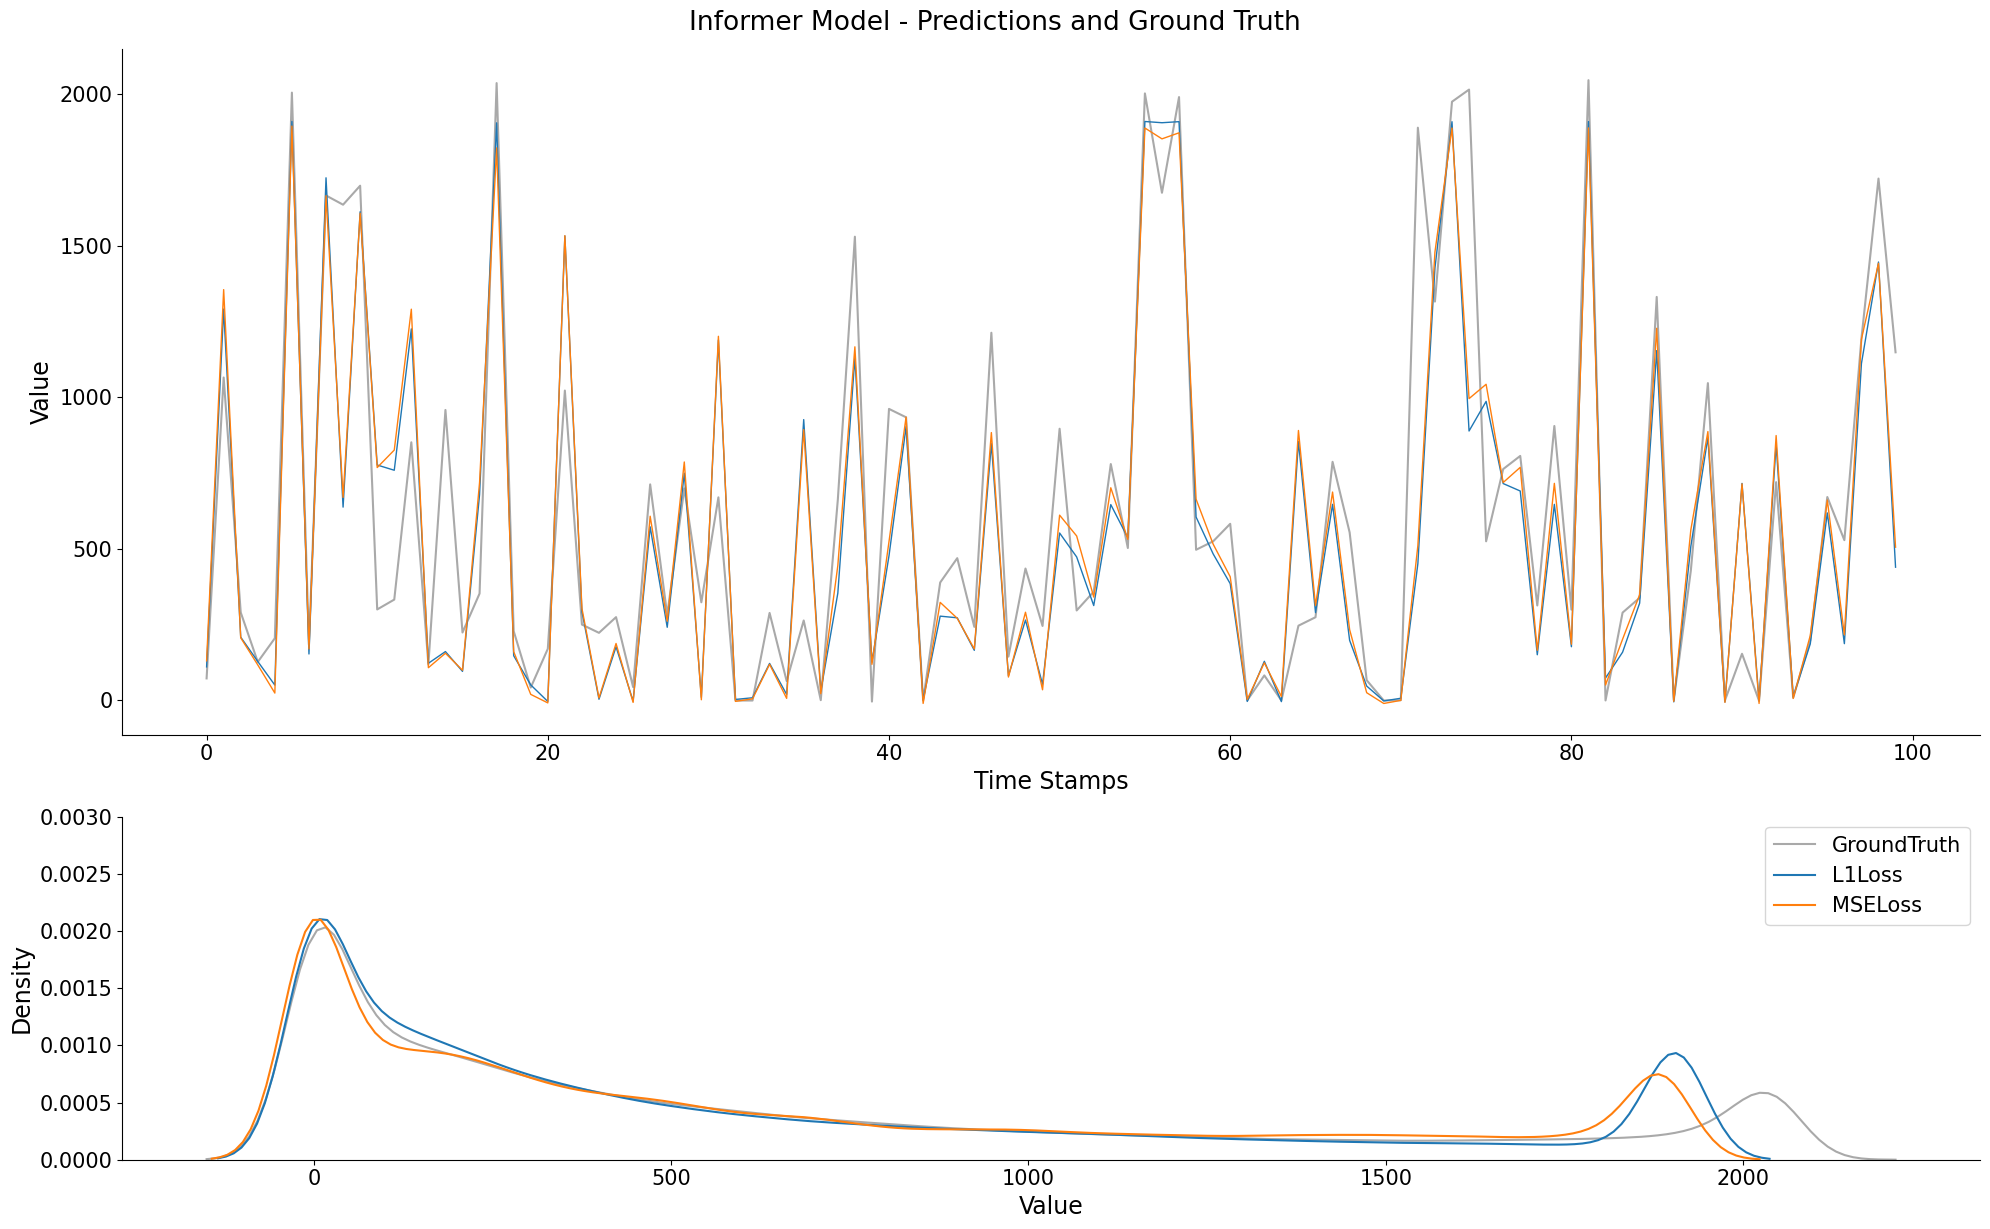

In [17]:
def eval_df_with_kde(model, data_frames, prediction_length, embedding_length=32, exclude_loss_functions=[], tick_size=10):
    """
    Aggregate predictions by model and loss function for 'eval' keys from the data frames,
    and plot both time series and KDE plots of predictions and ground truth, excluding specified loss functions from the KDE plot.
    Now includes manual setting for tick sizes and modified KDE plot height.

    Parameters:
    - model: String value of the Model to test.
    - data_frames: Dictionary mapping keys to pandas DataFrames.
    - prediction_length: Integer, the length of the prediction period.
    - embedding_length: Integer, the dimension of embedding. Default is 32.
    - exclude_loss_functions: List of loss function names to exclude from the KDE plot.
    - tick_size: Integer, size of the ticks in the plots.

    Returns:
    - A matplotlib figure with time series and KDE plots.
    """
    # Initialize placeholders
    ground_truths = []
    predictions = {}
    
    # Loop over each key to process 'eval' data frames
    for key in data_frames.keys():
        if 'eval' in key and key[1] == model and key[2] == embedding_length and key[3] == prediction_length:
            _, _, _, _, loss_function = key
            df = data_frames[key]
            
            # Extend the ground truths if this is a larger set
            if len(df) > len(ground_truths):
                ground_truths = df['GroundTruth'].str.strip('[]').astype(float).tolist()
            
            # Store predictions keyed by loss function
            predictions[loss_function] = df['Predictions'].str.strip('[]').astype(float).tolist()            
    
    # Determine the maximum length needed for any column
    max_length = max(len(ground_truths), max(len(pred) for pred in predictions.values()))
    
    # Pad all prediction lists to the max length with NaN
    for loss_function in predictions:
        current_length = len(predictions[loss_function])
        if current_length < max_length:
            predictions[loss_function].extend([np.nan] * (max_length - current_length))
    
    # Assemble the final DataFrame
    aggregated_data = {'GroundTruth': ground_truths[:max_length]}
    aggregated_data.update(predictions)
    aggregated_df = pd.DataFrame(aggregated_data)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 0.5]})
    tick_size=15
    
    # Time Series plot
    sns.lineplot(ax=ax1, x=range(len(aggregated_df[:100])), y=aggregated_df[:100]['GroundTruth'], 
                 label='GroundTruth', color='darkgrey', linewidth=1.5)
    for column in [col for col in aggregated_df.columns if col not in exclude_loss_functions and col != 'GroundTruth']:
        sns.lineplot(ax=ax1, x=range(len(aggregated_df[:100])), y=aggregated_df[:100][column], 
                     label=column, linewidth=1)
    ax1.set_xlabel('Time Stamps', fontsize=(tick_size + 2))
    ax1.set_ylabel('Value', fontsize=(tick_size + 2))
    ax1.legend().set_visible(False)
    ax1.tick_params(labelsize=tick_size)

    # KDE plot
    sns.kdeplot(ax=ax2, data=aggregated_df['GroundTruth'], label='GroundTruth', color='darkgrey')
    for column in [col for col in aggregated_df.columns if col not in exclude_loss_functions and col != 'GroundTruth']:
        sns.kdeplot(ax=ax2, data=aggregated_df[column], label=column)
    ax2.set_ylim([0, 0.003])  # Adjust the y-axis limit to make the plot half as high
    ax2.set_xlabel('Value', fontsize=(tick_size + 2))
    ax2.set_ylabel('Density', fontsize=(tick_size + 2))
    ax2.legend(title_fontsize=(tick_size + 1), fontsize=(tick_size))
    ax2.tick_params(labelsize=tick_size)

    sns.despine()  # Remove spines on right and top side
    plt.tight_layout()
    fig.suptitle(f'{model} Model - Predictions and Ground Truth', fontsize=(tick_size + 4), y=1.02)
    plt.savefig(f'../graphs/results/{model}_pred{prediction_length}_analysis.png', dpi=600, bbox_inches='tight')
    plt.show()

# Example usage:
eval_df_with_kde('Informer', DL_dfs, prediction_length=6, exclude_loss_functions=[])


# Test Area

In [43]:
DL_dfs.keys()

dict_keys([('eval', 'eFormer', 64, 1, 'CRPS'), ('epoch', 'VanillaTransformer', 64, 72, 'L1Loss'), ('epoch', 'eFormer', 32, 1, 'CRPS'), ('SystemUsage', 'eFormer', 64, 1, 'MSELoss'), ('epoch', 'VanillaTransformer', 64, 72, 'MSELoss'), ('eval', 'eFormer', 64, 6, 'MSELoss'), ('eval', 'Informer', 64, 6, 'CRPS'), ('epoch', 'eFormer', 128, 6, 'L1Loss'), ('epoch', 'eFormer', 64, 1, 'MSELoss'), ('SystemUsage', 'eFormer', 128, 6, 'L1Loss'), ('eval', 'eFormer', 32, 1, 'CRPS'), ('eval', 'VanillaTransformer', 64, 6, 'CRPS'), ('epoch', 'eFormer', 64, 6, 'L1Loss'), ('epoch', 'VanillaTransformer', 64, 1, 'L1Loss'), ('eval', 'VanillaTransformer', 64, 1, 'CRPS'), ('eval', 'eFormer', 32, 6, 'MSELoss'), ('epoch', 'eFormer', 64, 1, 'CrossEntropyLoss'), ('SystemUsage', 'Informer', 64, 6, 'CRPS'), ('eval', 'eFormer', 64, 1, 'MSELoss'), ('eval', 'eFormer', 128, 6, 'L1Loss'), ('eval', 'VanillaTransformer', 64, 1, 'L1Loss'), ('epoch', 'Informer', 64, 6, 'CRPS'), ('SystemUsage', 'eFormer', 64, 1, 'CrossEntropyLo

In [154]:
DL_dfs[('eval', 'VanillaTransformer', 32, 6, 'L1Loss')]

,Unnamed: 0,Predictions,GroundTruth,TestLoss
0,0,[120.26251220703125],[71.52999877929688],694.508578
1,1,[1280.9300537109375],[1064.8199462890625],694.508578
2,2,[219.9676513671875],[289.3710632324219],694.508578
3,3,[139.97171020507812],[125.82268524169922],694.508578
4,4,[56.74883270263672],[204.13580322265625],694.508578
...,...,...,...,...
773115,773115,[1709.0841064453125],[1622.63037109375],694.508578
773116,773116,[11.065860748291016],[156.16000366210938],694.508578
773117,773117,[2.779956102371216],[114.84683990478516],694.508578
773118,773118,[1.7846229076385498],[29.37649154663086],694.508578


In [ ]:
import torch
import numpy as np
import glob
import pandas as pd
import re
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def parse_filename(filename):
    pattern = r'df_(.*?)_(.*?)(_emb)(\d+)_pred(\d+)_(.*?).csv'
    match = re.search(pattern, filename)
    if match:
        return {
            'model': match.group(1),
            'loss_function': match.group(2),
            'embedding_length': int(match.group(4)),
            'prediction_length': int(match.group(5))
        }
    else:
        return None

def load_data(file):
    df = pd.read_csv(file)
    df['Predictions'] = df['Predictions'].apply(eval)
    df['GroundTruth'] = df['GroundTruth'].apply(eval)
    features = torch.tensor(list(df['Predictions']), dtype=torch.float64)
    labels = torch.tensor(list(df['GroundTruth']), dtype=torch.float64)
    return TensorDataset(features, labels)

def evaluate_model(files_pattern, model, loss_fn, hyperparameters):
    files = glob.glob(files_pattern)
    results = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for file in files:
        data_info = parse_filename(file)
        if not data_info:
            continue
        
        dataset = load_data(file)
        test_loader = DataLoader(dataset, batch_size=512, shuffle=False)

        test_losses = []
        model.eval()
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                predictions, weights = multi_step_eFormer(model, features, hyperparameters['step_forecast'])
                test_loss = loss_fn(predictions[:-hyperparameters['step_forecast']], labels[hyperparameters['step_forecast']:])
                test_losses.append(test_loss.item())

        test_loss_avg = np.mean(test_losses)
        data_info['test_loss'] = test_loss_avg
        results.append(data_info)
    
    return pd.DataFrame(results)

# Example of usage:
# Define hyperparameters and other configurations
hyperparameters = {'step_forecast': 10}
model = None  # Your model here
loss_fn = None  # Your loss function here

# Call the function
results_df = evaluate_model_on_gpu('../data/Results/df_*_*_emb*_pred*_*.csv', model, loss_fn, hyperparameters)
print(results_df)


In [ ]:
def test_loss(data_frames):
    # Initialize placeholders
    ground_truths = []
    predictions = {}
    
    # Loop over each key to process 'eval' data frames
    for key in data_frames.keys():
        if 'eval' in key and key[1] == model and key[2] == prediction_length:
            _, _, _, _, loss_function = key
            df = data_frames[key]
            
            # Extend the ground truths if this is a larger set
            if len(df) > len(ground_truths):
                ground_truths = df['GroundTruth'].tolist()
            
            # Store predictions keyed by loss function
            predictions[loss_function] = df['Predictions'].str.strip('[]').astype(float).tolist()            
    
    # Determine the maximum length needed for any column
    max_length = max(len(ground_truths), max(len(pred) for pred in predictions.values()))
    
    # Pad all prediction lists to the max length with NaN
    for loss_function in predictions:
        current_length = len(predictions[loss_function])
        if current_length < max_length:
            predictions[loss_function].extend([np.nan] * (max_length - current_length))
    
    # Assemble the final DataFrame
    aggregated_data = {'GroundTruth': ground_truths[:max_length]}
    aggregated_data.update(predictions)
    aggregated_df = pd.DataFrame(aggregated_data)